# Transformer boilerplate code + how to use it
##### by Daniel Melchor (dmh672@gmail.com)

---
## Imports

In [1]:
!pip install torch numpy matplotlib

In [2]:
import torch
import torch.nn as nn

import random
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [4]:
class Transformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/p/c80afbc9ffb1/
    """
    # Constructor
    def __init__(
        self,
        num_tokens,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
    ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=5000
        )
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model, num_tokens)
        
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)
        
        # We could use the parameter batch_first=True, but our KDL version doesn't support it yet, so we permute
        # to obtain size (sequence length, batch_size, dim_model),
        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)
        
        return out
      
    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return (matrix == pad_token)

Load the dataset for training and validation# Notice,we need to put SOS and EOS into the dataset; Compared with seq2se1 Code

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
fp = open('/content/drive/My Drive/project/i580w_jan 2012_input.txt','r')
input_data=[]
for line in fp:
    line=line.strip('\n')   #将\n去掉
    input_data.append(line.split(' '))   #将空格作为分隔符将一个字符切割成一个字符数组

fp.close()
input_data=np.array(input_data,dtype=int)   #将其转换成numpy的数组，并定义数据类型为float

fp = open('/content/drive/My Drive/project/i580w_jan 2012_target.txt','r')
target_data=[]
for line in fp:
    line=line.strip('\n')   #将\n去掉
    target_data.append(line.split(' '))   #将空格作为分隔符将一个字符切割成一个字符数组

fp.close()
target_data=np.array(target_data,dtype=int)   #将其转换成numpy的数组，并定义数据类型为float
#input_data = np.delete(input_data,[3,11,19],axis = 1) #delete the null column
#target_data = np.delete(target_data,[3],axis = 1)
#input_data = input_data[:,16:]
print("input data shape:",input_data.shape)
print("target data shape:",target_data.shape)
print(input_data[:8])
print(target_data[:8])

input data shape: (8925, 24)
target data shape: (8925, 8)
[[ 3 12  4  0  0  4  1  2  1  4  1  0  1  6  1  8  2  5  6  0  5  2  1  5]
 [ 1  4  1  0  1  6  1  8  2  5  6  0  5  2  1  5  2  6  6  0  4  4  0  9]
 [ 2  5  6  0  5  2  1  5  2  6  6  0  4  4  0  9  4  8 12  0  6  2  0 12]
 [ 2  6  6  0  4  4  0  9  4  8 12  0  6  2  0 12 11 11 10  0  2  4  2  9]
 [ 4  8 12  0  6  2  0 12 11 11 10  0  2  4  2  9 15  7 14  0  8  4  0  9]
 [11 11 10  0  2  4  2  9 15  7 14  0  8  4  0  9 13  7 13  0  4 12  2  9]
 [15  7 14  0  8  4  0  9 13  7 13  0  4 12  2  9  7 14 14  0  6  3  1 12]
 [13  7 13  0  4 12  2  9  7 14 14  0  6  3  1 12  9 11 24  0  6  1  3 11]]
[[ 2  6  6  0  4  4  0  9]
 [ 4  8 12  0  6  2  0 12]
 [11 11 10  0  2  4  2  9]
 [15  7 14  0  8  4  0  9]
 [13  7 13  0  4 12  2  9]
 [ 7 14 14  0  6  3  1 12]
 [ 9 11 24  0  6  1  3 11]
 [13 11 23  0  5  6  1 20]]


In [7]:
input_max = np.max(input_data, axis = 0)
input_min = np.min(input_data, axis = 0)
output_max = np.max(target_data, axis = 0)
output_min = np.min(target_data, axis = 0)

print("input max:{0},\n input min:{1},\n output max:{2},\n output min:{3}".format(input_max,input_min,output_max,output_min)) 


input max:[ 91 131 111   0  36  82  33 147  91 131 111   0  36  82  33 147  91 131
 111   0  36  82  33 147],
 input min:[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],
 output max:[ 91 131 111   0  36  82  33 147],
 output min:[0 0 0 0 0 0 0 0]


Add SOS and EOS

In [8]:
def addsoseos(X):
  SOS = np.ones([X.shape[0],1])*(150)
  EOS = np.ones([X.shape[0],1])*(152)
  X = np.c_[X,EOS]
  X = np.c_[SOS,X]
  return X

In [9]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
 

def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

In [10]:
# input_data = normalization(input_data) 
# target_data = normalization(target_data)
# print(input_data[:8])
# print(target_data[:8])

In [10]:
input_data = addsoseos(input_data)
target_data = addsoseos(target_data)

In [11]:
from sklearn.model_selection import train_test_split
import torch.utils.data as Data

X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [12]:
print(X_train.shape)
print(y_train.shape)

(6426, 26)
(6426, 10)


In [13]:
Batch_Size = 16
train_dataset = Data.TensorDataset(torch.from_numpy(X_train),torch.from_numpy(y_train))

#load training data
train_dataloader = Data.DataLoader(dataset = train_dataset,
                 batch_size = Batch_Size,
                 shuffle = True)

val_dataset = Data.TensorDataset(torch.from_numpy(X_val),torch.from_numpy(y_val))
#load validation data
val_dataloader = Data.DataLoader(dataset = val_dataset,
                 batch_size = Batch_Size,
                 shuffle = False)

test_dataset = Data.TensorDataset(torch.from_numpy(X_test),torch.from_numpy(y_test))
#load testing data
test_loader = Data.DataLoader(dataset = test_dataset,
                 batch_size = Batch_Size,
                 shuffle = False)


In [ ]:
#add SOS and EOS
# def generate_smaple(X,y):#X:6426*21; y:6426*7
#   data = []
#   SOS_token = np.array([2])#start of token
#   EOS_token = np.array([3])#start of token
#   for i in range(X.shape[0]):
#     data_X = np.concatenate((SOS_token, X[i].ravel(), EOS_token))
#     data_y = np.concatenate((SOS_token, y[i].ravel(), EOS_token))
#     data.append([data_X, data_y])
#   np.random.shuffle(data)
#   return data

In [ ]:
# train_data = generate_smaple(X_train,y_train)
# print(train_data[1])
# print(train_data[1][0])
# print(train_data[1][1])
# print(np.shape(train_data))

In [14]:
def generate_random_data(n):
    SOS_token = np.array([2])#start of token
    EOS_token = np.array([3])#end of token
    print(SOS_token)
    print(EOS_token)
    length = 5

    data = []

    # 1,1,1,1,1,1 -> 1,1,1,1,1
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])

    # 0,0,0,0 -> 0,0,0,0
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    # 1,0,1,0 -> 1,0,1,0,1
    for i in range(n // 3):
        X = np.zeros(length)
        start = random.randint(0, 1)

        X[start::2] = 1

        y = np.zeros(length)
        if X[-1] == 0:
            y[::2] = 1
        else:
            y[1::2] = 1

        X = np.concatenate((SOS_token, X, EOS_token))
        y = np.concatenate((SOS_token, y, EOS_token))

        data.append([X, y])

    np.random.shuffle(data)

    return data


def batchify_data(data, batch_size=16, padding=False, padding_token=-1):
    batches = []
    for idx in range(0, len(data), batch_size):
        # We make sure we dont get the last bit if its not batch_size size
        if idx + batch_size < len(data):
            # Here you would need to get the max length of the batch,
            # and normalize the length with the PAD token.
            if padding:
                max_batch_length = 0

                # Get longest sentence in batch
                for seq in data[idx : idx + batch_size]:
                    if len(seq) > max_batch_length:
                        max_batch_length = len(seq)

                # Append X padding tokens until it reaches the max length
                for seq_idx in range(batch_size):
                    remaining_length = max_bath_length - len(data[idx + seq_idx])
                    data[idx + seq_idx] += [padding_token] * remaining_length

            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

    print(f"{len(batches)} batches of size {batch_size}")

    return batches


# train_data = generate_random_data(9000)
# val_data = generate_random_data(3000)


# print(train_data[1][0])
# print(train_data[1][1])
# print(train_data[3])
# print(np.shape(train_data))
# train_dataloader = batchify_data(train_data)
# val_dataloader = batchify_data(val_data)
# print(train_dataloader[1])

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(
    num_tokens=160, dim_model=8, num_heads=8, num_encoder_layers=4, num_decoder_layers=4, dropout_p=0.1
).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [16]:
def train_loop(model, opt, loss_fn, dataloader):
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        #X, y = batch[:, 0], batch[:, 1]
        X = batch[0].long()
        y = batch[1].long()
        #print(X.dtype)
        #print(y.dtype)
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]
        
        # Get mask to mask out the next words
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # Standard training except we pass in y_input and tgt_mask
        pred = model(X, y_input, tgt_mask)

        # Permute pred to have batch size first again
        pred = pred.permute(1, 2, 0)      
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [17]:
def validation_loop(model, loss_fn, dataloader):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            X = batch[0].long()
            y = batch[1].long()
           # X, y = batch[:, 0], batch[:, 1]
          #  X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)
            X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)
            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = y[:,:-1]
            y_expected = y[:,1:]
            
            # Get mask to mask out the next words
            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            # Standard training except we pass in y_input and src_mask
            pred = model(X, y_input, tgt_mask)

            # Permute pred to have batch size first again
            pred = pred.permute(1, 2, 0)
            # print("expected:",y_expected.shape)
            # print("pred:",pred.shape)      
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [18]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    # Used for plotting later on
    train_loss_list, validation_loss_list = [], []
    
    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        
        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        
        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]
        
        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()
        
    return train_loss_list, validation_loss_list
    
train_loss_list, validation_loss_list = [], []

In [19]:
train_loss_lt, val_loss_lt = fit(model, opt, loss_fn, train_dataloader, val_dataloader, 150)
train_loss_list += train_loss_lt 
validation_loss_list += val_loss_lt

Training and validating model
------------------------- Epoch 1 -------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Training loss: 3.7339
Validation loss: 3.3229

------------------------- Epoch 2 -------------------------
Training loss: 3.1600
Validation loss: 2.9466

------------------------- Epoch 3 -------------------------
Training loss: 2.8389
Validation loss: 2.5547

------------------------- Epoch 4 -------------------------
Training loss: 2.6302
Validation loss: 2.4291

------------------------- Epoch 5 -------------------------
Training loss: 2.5505
Validation loss: 2.3502

------------------------- Epoch 6 -------------------------
Training loss: 2.4855
Validation loss: 2.3388

------------------------- Epoch 7 -------------------------
Training loss: 2.4434
Validation loss: 2.2663

------------------------- Epoch 8 -------------------------
Training loss: 2.4084
Validation loss: 2.2496

------------------------- Epoch 9 -------------------------
Training loss: 2.3859
Validation loss: 2.2226

------------------------- Epoch 10 -------------------------
Training loss: 2.3634
Validation los

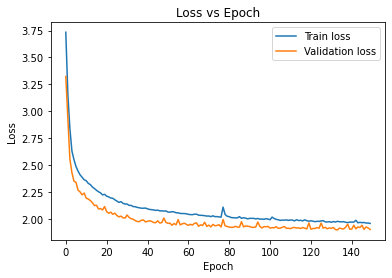

In [20]:
plt.plot(train_loss_list, label = "Train loss")
plt.plot(validation_loss_list, label = "Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [21]:
def test_loop(model, loss_fn, dataloader):
    model.eval()
    total_loss = 0

    mape = 0
    smape = 0
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for batch in dataloader:
            X = batch[0].long()
            y = batch[1].long()
           # X, y = batch[:, 0], batch[:, 1]
          #  X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)
            X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)
            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = y[:,:-1]
            y_expected = y[:,1:]
            # print(y_expected)
            
            # Get mask to mask out the next words
            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            # Standard training except we pass in y_input and src_mask
            pred = model(X, y_input, tgt_mask)

            # Permute pred to have batch size first again
            pred = pred.permute(1, 2, 0)
            # print("expected:",y_expected.shape)
            # print("pred:",pred.shape)

            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()


            pred_class = torch.argmax(pred, dim=1)
            pred_class = pred_class.reshape(-1)
            y_expected = y_expected.reshape(-1)

            epoch_mape = torch.abs(100 * (y_expected - pred_class) / (y_expected + 0.01)).sum().data
            epoch_smape = torch.abs(200 * (y_expected - pred_class) / (y_expected + pred_class + 0.01)).sum().data

            mape += epoch_mape
            smape += epoch_smape            

            y_pred += pred_class.tolist()
            y_true += y_expected.tolist()
        
    return total_loss / len(dataloader), y_true, y_pred, mape, smape
test_loss, y_true, y_pred, mape, smape = test_loop(model, loss_fn, test_loader)

mape = mape / (len(test_dataset) * 8)
smape = smape / (len(test_dataset) * 8)

print("test_loss", test_loss)
print("MAPE ", mape.item())
print("SMAPE ", smape.item())

import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(y_true, y_pred) * 8
mse = metrics.mean_squared_error(y_true, y_pred) * 8
rmse = mse ** (1/2)

print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", rmse)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


test_loss 1.8713531121611595
MAPE  371.84857177734375
SMAPE  27.716693878173828
MAE:  23.48210395269219
MSE:  276.07793339558043
RMSE:  16.615593079862677


In [22]:
num = 0
for i in range(len(y_pred)):
  if y_pred[i] == y_true[i]:
    num += 1
precision = num / len(y_pred)
print("Precision: ", precision)

Precision:  0.4343604108309991


In [23]:
def predict(model, input_sequence, max_length=15, SOS_token=150, EOS_token=152):
    model.eval()
    
    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)
        
        pred = model(input_sequence, y_input, tgt_mask)
        
        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()
  
  
# Here we test some examples to observe how the model predicts
examples = []
m = 0
for batch in train_dataloader:
  X = batch[0].long()
  y = batch[1].long()
  #X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)
  print(X[0])
  m = m + 1
  if m > 0:
    break

examples = [X[0],X[1],X[2],X[3]]
print(examples)
print(y[0])
print(y[1])
print(y[2])
print(y[3])

examples = [
    #torch.tensor([train_dataloader[1]], dtype=torch.long, device=device),
    torch.tensor([[150,   5,  10,   4,   0,   2,  10,   2,   9,   2,   9,   3,   0,   3, 9,   1,   7,   2,   7,   4,   0,   3,   2,   2,   7, 152]], dtype=torch.long, device=device),
    torch.tensor([[150,  30,  81,  72,   0,  18,  38,   7,  66,  36,  79,  70,   0,  24,
         31,   6,  71,  50,  80,  83,   0,  14,  28,   6,  79, 152]], dtype=torch.long, device=device),
    torch.tensor([[150,   9,  15,  10,   0,   1,   3,   2,  18,   5,  13,   7,   0,   1,
          8,   0,  15,   9,  11,   8,   0,   1,   5,   0,   9, 152]], dtype=torch.long, device=device),
    torch.tensor([[150,  42,  31,  38,   0,  13,  60,  16,  31,  35,  34,  27,   0,  20,
         43,  12,  32,  47,  34,  37,   0,  16,  58,  14,  43, 152]], dtype=torch.long, device=device),
   # torch.tensor([[150, 13,  7, 13,  0,  4, 12,  2,  9, 100]], dtype=torch.long, device=device)
    # torch.tensor([[2, 0, 0, 0, 4, 0, 3]], dtype=torch.long, device=device),
    # torch.tensor([[2, 1, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),
    # torch.tensor([[2, 1, 0, 1, 6, 1, 3]], dtype=torch.long, device=device),
    # torch.tensor([[2, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    # torch.tensor([[2, 0, 1, 0, 7, 0, 3]], dtype=torch.long, device=device),
    # torch.tensor([[2, 0, 1, 0, 1, 1, 3]], dtype=torch.long, device=device)
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

tensor([150,   1,   1,   2,   0,   1,   3,   1,   3,   2,   2,   4,   0,   0,
          5,   1,   1,   4,   4,   6,   0,   3,   7,   1,   5, 152])
[tensor([150,   1,   1,   2,   0,   1,   3,   1,   3,   2,   2,   4,   0,   0,
          5,   1,   1,   4,   4,   6,   0,   3,   7,   1,   5, 152]), tensor([150,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 152]), tensor([150,  38,  65,  37,   0,   3,  19,   3,  62,  30,  55,  45,   0,   2,
         23,   1,  54,  32,  53,  49,   0,   4,  23,   3,  57, 152]), tensor([150,  71,  79,  77,   0,   5,  36,   9,  90,  57,  87,  63,   0,   7,
         33,  11,  82,  55,  71,  69,   0,   5,  36,   8, 102, 152])]
tensor([150,   1,   5,   2,   0,   2,   5,   1,   5, 152])
tensor([150,   0,   0,   0,   0,   0,   0,   0,   0, 152])
tensor([150,  32,  52,  48,   0,   4,  24,   5,  60, 152])
tensor([150,  65,  98,  80,   0,   4,  35,  12, 104, 152])
Example 0
Input: [5, 10,